In [26]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torch.nn as nn
from torchvision import transforms, models, datasets
import imageio
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image

In [15]:
data_dir = 'E:/flower_data/'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [16]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.1,saturation=0.1,hue=0.1),
        transforms.RandomGrayscale(0.025),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}

In [17]:
batch_size = 8

image_datasets = { x: datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x]) for x in ['train', 'valid'] }
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']}
data_sizes = {x:len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [18]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 6552
     Root location: E:/flower_data/train
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
                CenterCrop(size=(224, 224))
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
                RandomGrayscale(p=0.025)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 818
     Root location: E:/flower_data/valid
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.45

In [19]:
with open(data_dir+'cat_to_name.json') as f:
    cat_to_name = json.load(f)
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

In [20]:
def im_covert(tensor):
    image = tensor.to('cpu').clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229,0.224,0.225))+np.array((0.485,0.456,0.406))
    image - image.clip(0,1)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


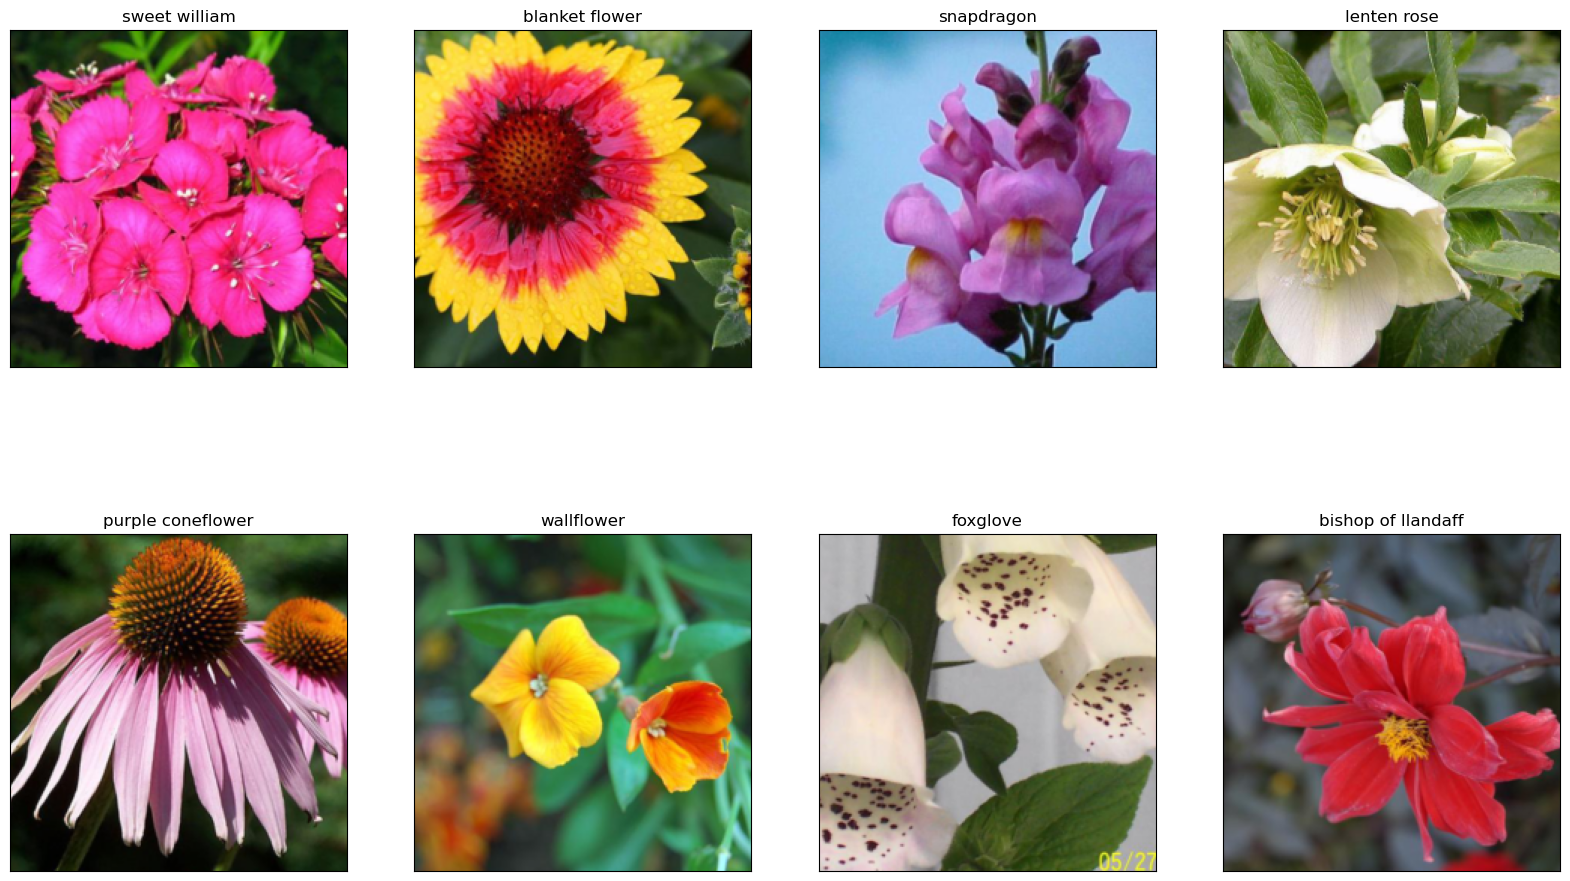

In [21]:
fig = plt.figure(figsize=(20,12))
columns = 4
rows = 2
dataiter = iter(dataloaders['valid'])
inputs, classes = dataiter.__next__()
for idx in range(columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    ax.set_title(cat_to_name[str(int(class_names[classes[idx]]))])
    plt.imshow(im_covert(inputs[idx]))
plt.show()

In [22]:
model_name = 'resnet'
feature_extract = True

In [23]:
train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda:0")

In [24]:
def set_parameter_requires_gard(model, feature_extracting):
    if feature_extracting:
        for parm in model.parameters():
            parm.requires_gard = False

In [25]:
model_ft = models.resnet152()
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
def initialize_model():
    model_ft = None
    input_size = 0
    
    if model_name == "resnet":
        model_ft = models.resnet152(pretrained=False)
        set_parameter_requires_gard(model_ft, feature_extract)
        num_fits = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(nn.Linear(num_fits, 102),nn.LogSoftmax(dim=1))
        input_size = 224
    
    return model_ft, input_size
    

In [32]:
model_ft, input_size = initialize_model()

In [33]:
model_ft = model_ft.to(device)
filename = 'E:\checkpoint.pth'
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [34]:
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
criterion = nn.NLLLoss()

In [35]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, filename=filename):
    since = time.time()
    best_acc = 0
    
    model.to(device)
    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['1r']]
    
    best_model_wts = copy.deepcopy(model.state_dict())
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
        
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
        optimizer.zero_gard()
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds  = torch.max(outputs, 1)
            if phase == 'train':
                loss.backward()
                optimizer.setp()
        
        running_loss += loss.item() * input_size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(dataloaders[phase].dataset)
    epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
    
    time_elapsed = time.time() - since
    print('time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase,epoch_loss, epoch_acc))
    
    